#### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

from scipy.interpolate import interp1d # for time interpolation

from Sports2D import Sports2D

# importing custom plotting functions
from plotting_functions import plot_joint_angle, plot_all_joints

#### Helper Function

In [2]:
import os
def list_filepaths(directory, extension):
    """
    Lists all *extension* files in the specified directory and its subdirectories.
    
    Parameters:
    directory (str): The path to the directory.
    extension (str): The file extension to look for.
    
    Returns:
    list: A list of file paths to *extension* files in the directory and subdirectories.
    """
    files = []
    for root, _, filenames in os.walk(directory):
        for file in filenames:
            if file.endswith(str(extension)):
                files.append(os.path.join(root, file))
    return files

#### Analysing the video's

In [ ]:
# Set this to true if you need to re-analyse the videos :)
run_sports2d_analysis = True

In [ ]:
import os
from Sports2D import Sports2D

# Define paths relative to the current script/notebook directory
script_dir = os.path.dirname(__file__) if '__file__' in locals() else os.getcwd()
video_dir = os.path.normpath(os.path.join(script_dir, "../Videos to Analyze/Start Salto")) # switch to /Start Salto
config_path = os.path.normpath(os.path.join(script_dir, "../Configs/kraftspring_config_7nov.toml")) # still need to manually move analyzed videos and data to their respective folders (or change it in config)
data_dir = os.path.normpath(os.path.join(script_dir, "../Analyzed Data"))

# Specific move directories
kraft_data_dir = os.path.normpath(os.path.join(script_dir, "../Analyzed Data/Kraft"))
st_salto_data_dir = os.path.normpath(os.path.join(script_dir, "../Analyzed Data/Start Salto"))




# Get a list of all video files in the directory
video_files = list_filepaths(video_dir, ".mp4")

# Load the configuration file
config = Sports2D.read_config_file(config_path)


In [5]:
# Update the video input in the config and process each video

if run_sports2d_analysis == True:
    for video_file in video_files:
        try:
            config['project']['video_input'] = [video_file]
            Sports2D.process(config)
        except Exception as e:
            print(f"Error processing video {video_file}: {e}")

#### Loading Data

In [6]:
def load_trc_file(file_path):
    """
    Loads a .trc motion capture file into a Pandas DataFrame, handling multi-line headers and pairing marker names with coordinates.
    
    Parameters:
    file_path (str): The path to the .trc file.
    
    Returns:
    tuple: A tuple containing the header information (as a dict) and the data (as a DataFrame).
    """
    # Read the entire file to access header lines
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    # Extract header information from the first three lines
    headers = {
        'PathFileType': lines[0].strip(),
        'Data Info': lines[1].strip(),
        'Rates and Frames': lines[2].strip()
    }
    
    # Extract marker names and coordinate labels from the last two header lines
    marker_names = lines[3].strip().split()  # e.g., ['Frame#', 'Time', 'Hip', 'RHip', ...]
    coordinate_labels = lines[4].strip().split()  # e.g., ['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2', ...]

    # Combine marker names with coordinate labels to form complete column names
    column_names = []
    marker_index = 2  # Start at 2 to skip 'Frame#' and 'Time'
    for coord in coordinate_labels:
        if coord.startswith('X'):
            column_names.append(f"{marker_names[marker_index]}_X")
        elif coord.startswith('Y'):
            column_names.append(f"{marker_names[marker_index]}_Y")
        elif coord.startswith('Z'):
            column_names.append(f"{marker_names[marker_index]}_Z")
            marker_index += 1

    # Prepend 'Frame#' and 'Time' to the column names
    column_names = ['Frame#', 'Time'] + column_names
    
    # Create the DataFrame starting from the data rows (after the header)
    data_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=column_names)
    
    return headers, data_df

In [7]:
def load_mot_file(file_path):
    """
    Loads a .mot file containing joint angles into a Pandas DataFrame.
    
    Parameters:
    file_path (str): The path to the .mot file.
    
    Returns:
    tuple: A tuple containing metadata (as a dict) and the data (as a DataFrame).
    """
    metadata = {}
    data_lines = []
    
    with open(file_path, 'r') as file:
        # Read and parse the header
        line = file.readline().strip()
        while line != "endheader":
            if '=' in line:
                key, value = line.split('=')
                metadata[key.strip()] = value.strip()
            line = file.readline().strip()
        
        # Read the column headers line
        column_headers_line = file.readline().strip()
        column_headers = column_headers_line.split('\t')  # Split by tabs if columns are tab-separated
        column_headers = [col.replace(' ', '_') for col in column_headers]  # Replace spaces in column names with underscores
        
        # Read the data lines
        for line in file:
            data_lines.append(line.strip().split('\t'))  # Split by tabs if data is tab-separated

    # Convert data to DataFrame
    data_df = pd.DataFrame(data_lines, columns=column_headers)
    
    # Convert numerical columns from string to float
    data_df = data_df.apply(pd.to_numeric, errors='coerce')

    return metadata, data_df

In [8]:
def extract_identifiers(file_path):
    """
    Extracts move, evaluation, participant ID, video number, and person tracked from the file path.
    
    Parameters:
    file_path (str): The path to the file.
    
    Returns:
    tuple: A tuple containing move, evaluation, participant ID, video number, and person tracked.
    """
    # Regex to extract identifiers from the path after "Sports2D/"
    match = re.search(r"Sports2D/([^_]+)_(good|bad)_id(\d+)_(\d+)_.*_(person\d+)", file_path)
    if match:
        move, evaluation, participant_id, video_number, person_tracked = match.groups()
        return move, evaluation, f"id{participant_id}_{person_tracked}", video_number
    else:
        raise ValueError(f"Cannot extract identifiers from the file path: {file_path}")

def load_multiple_files(file_paths, file_type='trc'):
    """
    Loads multiple .trc or .mot files into a combined DataFrame with participant identifiers.

    Parameters:
    file_paths (list of str): List of paths to the .trc or .mot files.
    file_type (str): Type of file to load ('trc' or 'mot').

    Returns:
    pd.DataFrame: A combined DataFrame with participant ID as a key and other metadata as columns.
    """
    data_list = []
    
    for path in file_paths:
        try:
            move, evaluation, participant_key, video_number = extract_identifiers(path)
            
            if file_type == 'trc':
                _, data_df = load_trc_file(path)
            elif file_type == 'mot':
                metadata, data_df = load_mot_file(path)
                # Optionally add metadata columns if needed
                for key, value in metadata.items():
                    data_df[key] = value
            
            # Add participant-specific information as new columns
            data_df['participant_id'] = participant_key
            data_df['move'] = move
            data_df['evaluation'] = evaluation
            data_df['video_number'] = video_number
            
            data_list.append(data_df)
        
        except ValueError as e:
            print(e)

    # Combine all DataFrames into a single DataFrame
    combined_df = pd.concat(data_list, ignore_index=True)
    return combined_df


#### Actually Loading the Data

In [9]:
# get file paths contained in analyzed video data
trc_file_paths = list_filepaths(data_dir, '.trc')
mot_file_paths = list_filepaths(data_dir, '.mot')

# create combined dataframes of them
trc_combined_df = load_multiple_files(trc_file_paths, file_type='trc')
mot_combined_df = load_multiple_files(mot_file_paths, file_type='mot')


In [10]:
print(f"Unique participants in mot_files {mot_combined_df['participant_id'].unique()}")
print(f"Unique participants in trc_files {trc_combined_df['participant_id'].unique()}")

print()
print(f"Unique moves in mot_files {mot_combined_df['move'].unique()}")
print(f"Unique moves in trc_files {trc_combined_df['move'].unique()}")

print()
print(f"Unique evaluations in mot_files {mot_combined_df['evaluation'].unique()}")
print(f"Unique evaluations in trc_files {trc_combined_df['evaluation'].unique()}")

print()
print(f"Unique video numbers in mot_files {mot_combined_df['video_number'].unique()}")
print(f"Unique video numbers in trc_files {trc_combined_df['video_number'].unique()}")

Unique participants in mot_files ['id2_person00' 'id5_person00' 'id3_person00' 'id1_person00']
Unique participants in trc_files ['id2_person00' 'id5_person00' 'id3_person00' 'id1_person00']

Unique moves in mot_files ['kraft']
Unique moves in trc_files ['kraft']

Unique evaluations in mot_files ['good' 'bad']
Unique evaluations in trc_files ['good' 'bad']

Unique video numbers in mot_files ['1' '2']
Unique video numbers in trc_files ['1' '2']


In [11]:
mot_combined_df.head()

,time,right_knee,left_knee,left_hip,right_shoulder,left_shoulder,right_elbow,left_elbow,version,nRows,nColumns,inDegrees,participant_id,move,evaluation,video_number
0,0.000000,101.097969,7.277865,68.480268,174.192347,114.094754,-38.207582,6.191491,1,258,7,yes,id2_person00,kraft,good,1
1,0.006971,101.122264,7.238547,68.518884,174.222379,114.053705,-38.263336,6.183936,1,258,7,yes,id2_person00,kraft,good,1
2,0.013943,101.150709,7.195587,68.543118,174.240329,114.016246,-38.298380,6.175673,1,258,7,yes,id2_person00,kraft,good,1
3,0.020914,101.183615,7.149052,68.549590,174.243401,113.983813,-38.307839,6.166714,1,258,7,yes,id2_person00,kraft,good,1
4,0.027886,101.221266,7.099094,68.534564,174.228512,113.958039,-38.286334,6.157085,1,258,7,yes,id2_person00,kraft,good,1


#### Plotting!

In [12]:
def plot_hip_trajectory(df):
    """
    Plots the hip position (X and Y) for multiple participants from a combined DataFrame,
    distinguishing between 'good' and 'bad' participants by line style.
    
    Parameters:
    df (pd.DataFrame): A DataFrame containing motion capture data with columns 'Hip_X', 'Hip_Y',
                       'participant_id', and 'evaluation'.
    """
    plt.figure(figsize=(12, 6))
    
    # Generate a color map for unique participants
    unique_participants = df['participant_id'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_participants)))
    color_map = {participant: color for participant, color in zip(unique_participants, colors)}
    
    # Plot hip trajectory for each participant
    for participant_id in unique_participants:
        participant_data = df[df['participant_id'] == participant_id]
        if 'Hip_X' in participant_data.columns and 'Hip_Y' in participant_data.columns:
            evaluation = participant_data['evaluation'].iloc[0]  # Get the evaluation value for the participant
            line_style = '-' if evaluation == 'good' else '--'
            plt.plot(participant_data['Hip_X'], participant_data['Hip_Y'],
                     label=f'{evaluation} - {participant_id}',
                     color=color_map[participant_id], linestyle=line_style)
        else:
            print(f"Warning: 'Hip_X' or 'Hip_Y' not found for {participant_id}")
    
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title('Hip Position in X-Y Plane Over Time for Multiple Participants')
    plt.legend()
    plt.grid(True)
    plt.show()


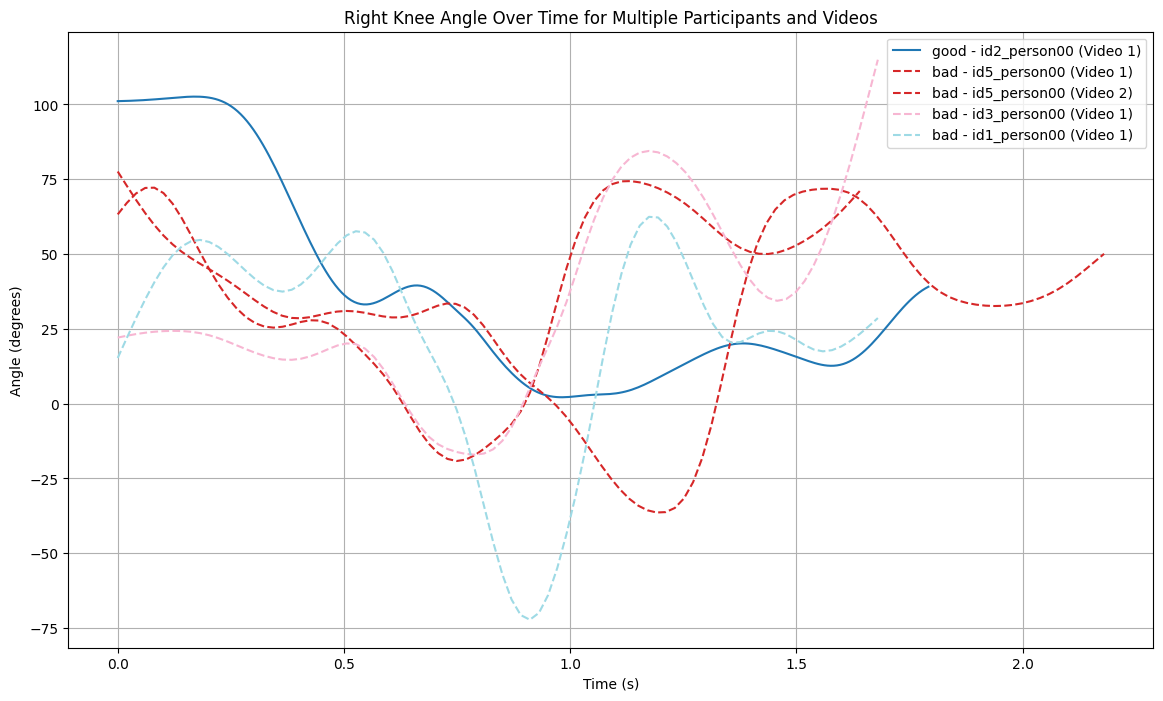

In [13]:
# Assuming combined_trc_df and combined_mot_df are DataFrames with motion capture data
#plot_hip_trajectory(trc_combined_df)
#standardized_trc_df = standardize_trc_data(trc_combined_df)
plot_joint_angle(mot_combined_df, 'right_knee')

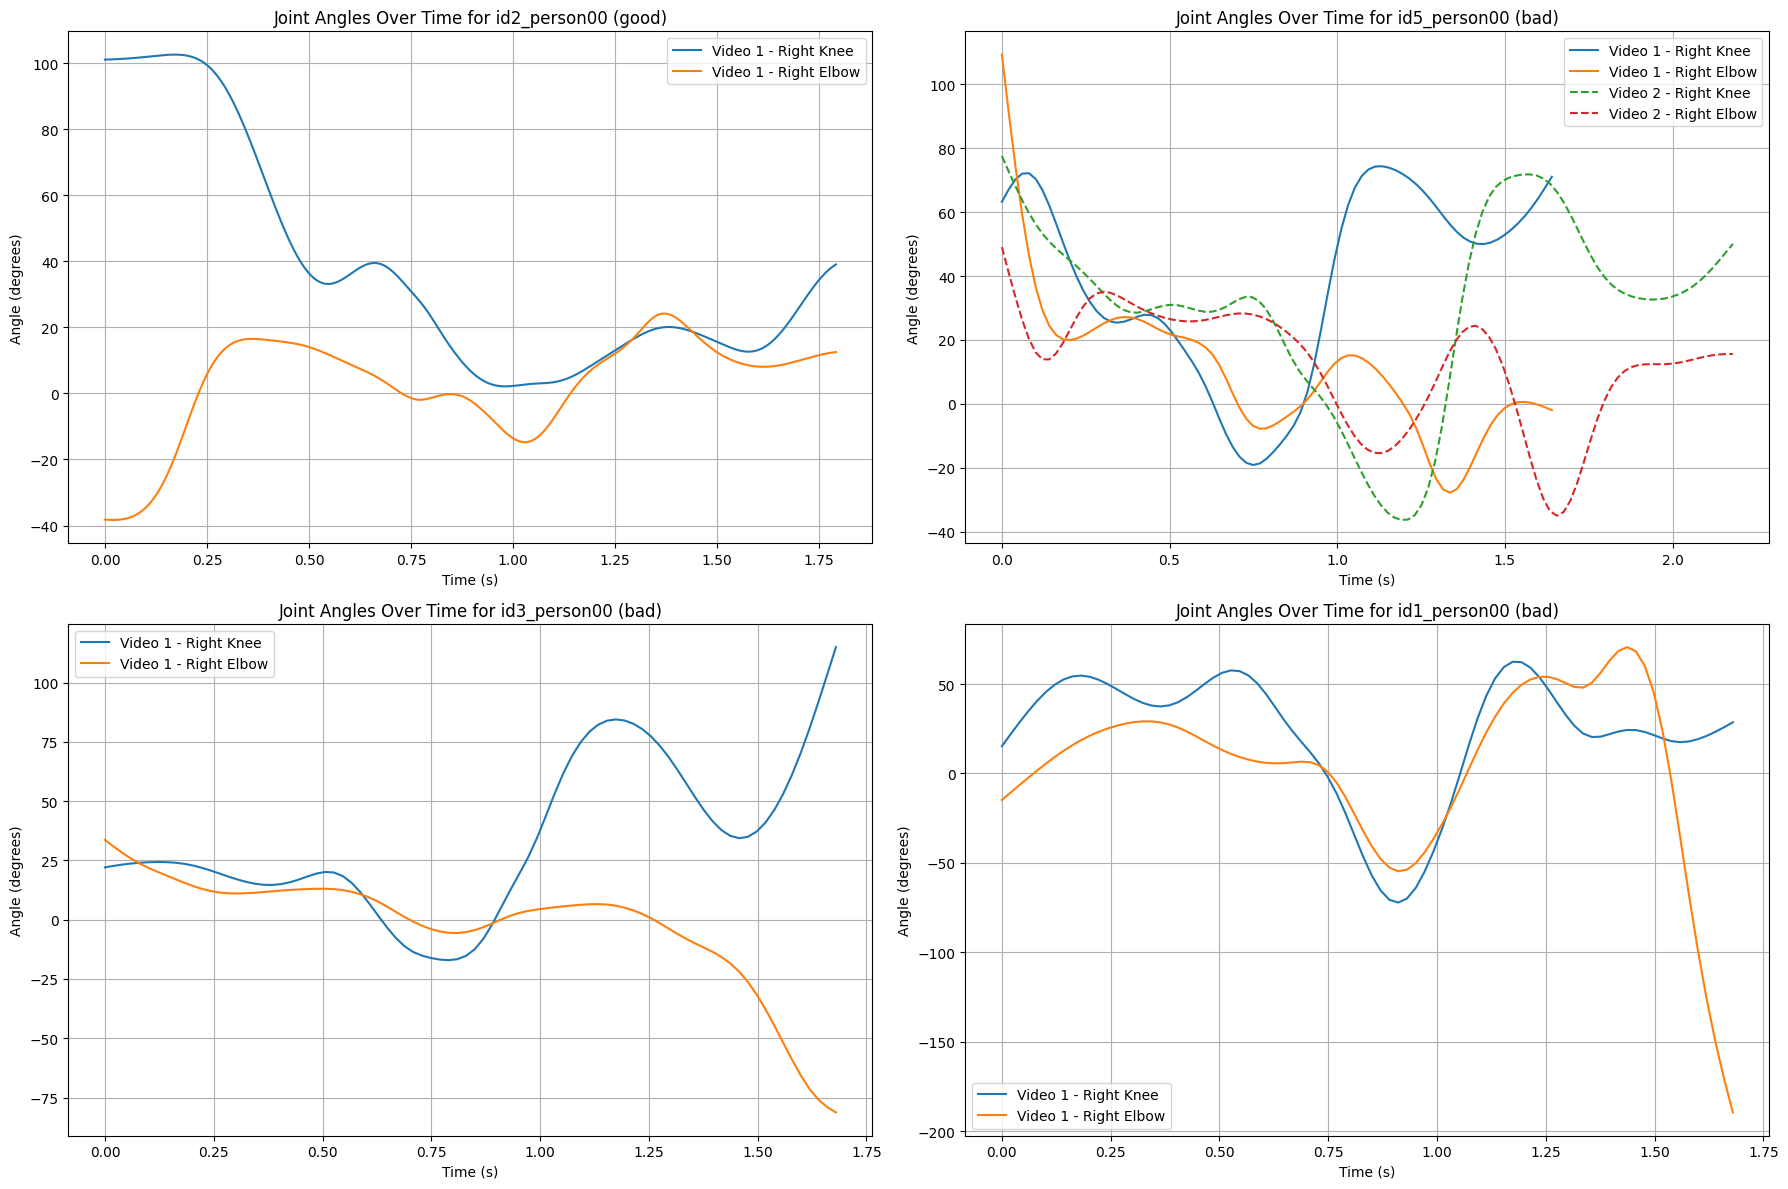

In [22]:
# Example usage with a DataFrame containing joint data
joint_names = ['right_knee', 'right_elbow']  # List of joints to plot
plot_all_joints(mot_combined_df, joint_names, grid=True, fig_size = (18, 6))
